## QUESTION
---
Conduct exploratory data analysis on the attached data and also implement Regression and Classification
models using the following guidelines
1. Conduct exploratory analysis of the data and provide a detailed description of the data
2. Implement regression modeling using 4 different regression algorithms to predict the age of employees
leaving the firm. Explain the results of each of the models and any variance observed
3. Implement classification modeling using 4 different classification algorithms models to predict the attrition
of employees leaving the firm. Explain the results of each of the models and any variance observed


## BINARY CLASSIFICATION
---
This is a binary classification problem that need me to build a predictive model to determine employee attrition.<br>
"Yes" is an employee is likely to leave the company and "No" otherwise.<br>

## DataWrangling and Exploratory Analysis
---
When conducting exploratory analysis there were no missing data nor duplicates and the initial shape of my dataset was (1470, 36) after wrangling it was (1470, 23).<br>
Following the wrangle function below you'll clearly see how some of the features were remove.<br>


In [35]:
#import libraries necessary for classification model `LogisticRegression`
import warnings

import pandas as pd
import numpy as np
import pickle # for saving the model as a file 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sns
from pandas import set_option
from sklearn.utils.validation import check_is_fitted
from imblearn.under_sampling import RandomUnderSampler #for balancing target class by undersampling majority class
from imblearn.over_sampling import RandomOverSampler # for balancing target class by oversampling minority class

warnings.simplefilter(action = "ignore", category = FutureWarning)

In [2]:
#creating a wrangle function
def wrangle(path):
    # load the data set to be used
    df =  pd.read_csv(path)
    
    #create new target column that is new attrition ("Emp_Attrition") column
    df["Emp_Attrition"] = [1 if  i == "Yes" else 0 for i in df["Attrition"]]
    
    # drop old target feature `Attrition`
    df.drop(columns="Attrition", inplace=True)
    
    # drop high/low cardinality features by low I mean only one unique record without a comparison
    df.drop(columns=["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"], inplace= True)
    
    # List of Leaky features
    df_leaky_features = [i for i in df.columns if "Years" in i]
    
    # Drop leaky features
    df.drop(columns = df_leaky_features, inplace=True)
    
    # dropping multicollinear features
    df.drop(columns=["Age", "MonthlyIncome", "PercentSalaryHike"], inplace=True)
    
    return df

In [3]:
df = wrangle("./WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head(10)

,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,Emp_Attrition
0,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,...,Single,19479,8,Yes,3,1,0,0,1,1
1,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,...,Married,24907,1,No,4,4,1,3,3,0
2,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,...,Single,2396,6,Yes,3,2,0,3,3,1
3,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,...,Married,23159,1,Yes,3,3,0,3,3,0
4,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,...,Married,16632,9,No,3,4,1,3,3,0
5,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,Male,79,3,...,Single,11864,0,No,3,3,0,2,2,0
6,Travel_Rarely,1324,Research & Development,3,3,Medical,3,Female,81,4,...,Married,9964,4,Yes,4,1,3,3,2,0
7,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,4,Male,67,3,...,Divorced,13335,1,No,4,2,1,2,3,0
8,Travel_Frequently,216,Research & Development,23,3,Life Sciences,4,Male,44,2,...,Single,8787,0,No,4,2,0,2,3,0
9,Travel_Rarely,1299,Research & Development,27,3,Medical,3,Male,94,3,...,Married,16577,6,No,3,2,2,3,2,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   BusinessTravel            1470 non-null   object
 1   DailyRate                 1470 non-null   int64 
 2   Department                1470 non-null   object
 3   DistanceFromHome          1470 non-null   int64 
 4   Education                 1470 non-null   int64 
 5   EducationField            1470 non-null   object
 6   EnvironmentSatisfaction   1470 non-null   int64 
 7   Gender                    1470 non-null   object
 8   HourlyRate                1470 non-null   int64 
 9   JobInvolvement            1470 non-null   int64 
 10  JobLevel                  1470 non-null   int64 
 11  JobRole                   1470 non-null   object
 12  JobSatisfaction           1470 non-null   int64 
 13  MaritalStatus             1470 non-null   object
 14  MonthlyRate             

There are no missing data on this data set as evident on the info method above

In [5]:
#df["Emp_Attrition"] = [1 if  i == "Yes" else 0 for i in df["Attrition"]]


In [6]:
df.columns

Index(['BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'Emp_Attrition'],
      dtype='object')

In [7]:
#df["YearsWithCurrManager"].nunique()

In [8]:
for i in df.columns:
    if "Years" in i:
        print(i)

In [9]:
df_leaky_features = [i for i in df.columns if "Years" in i]
df_leaky_features

[]

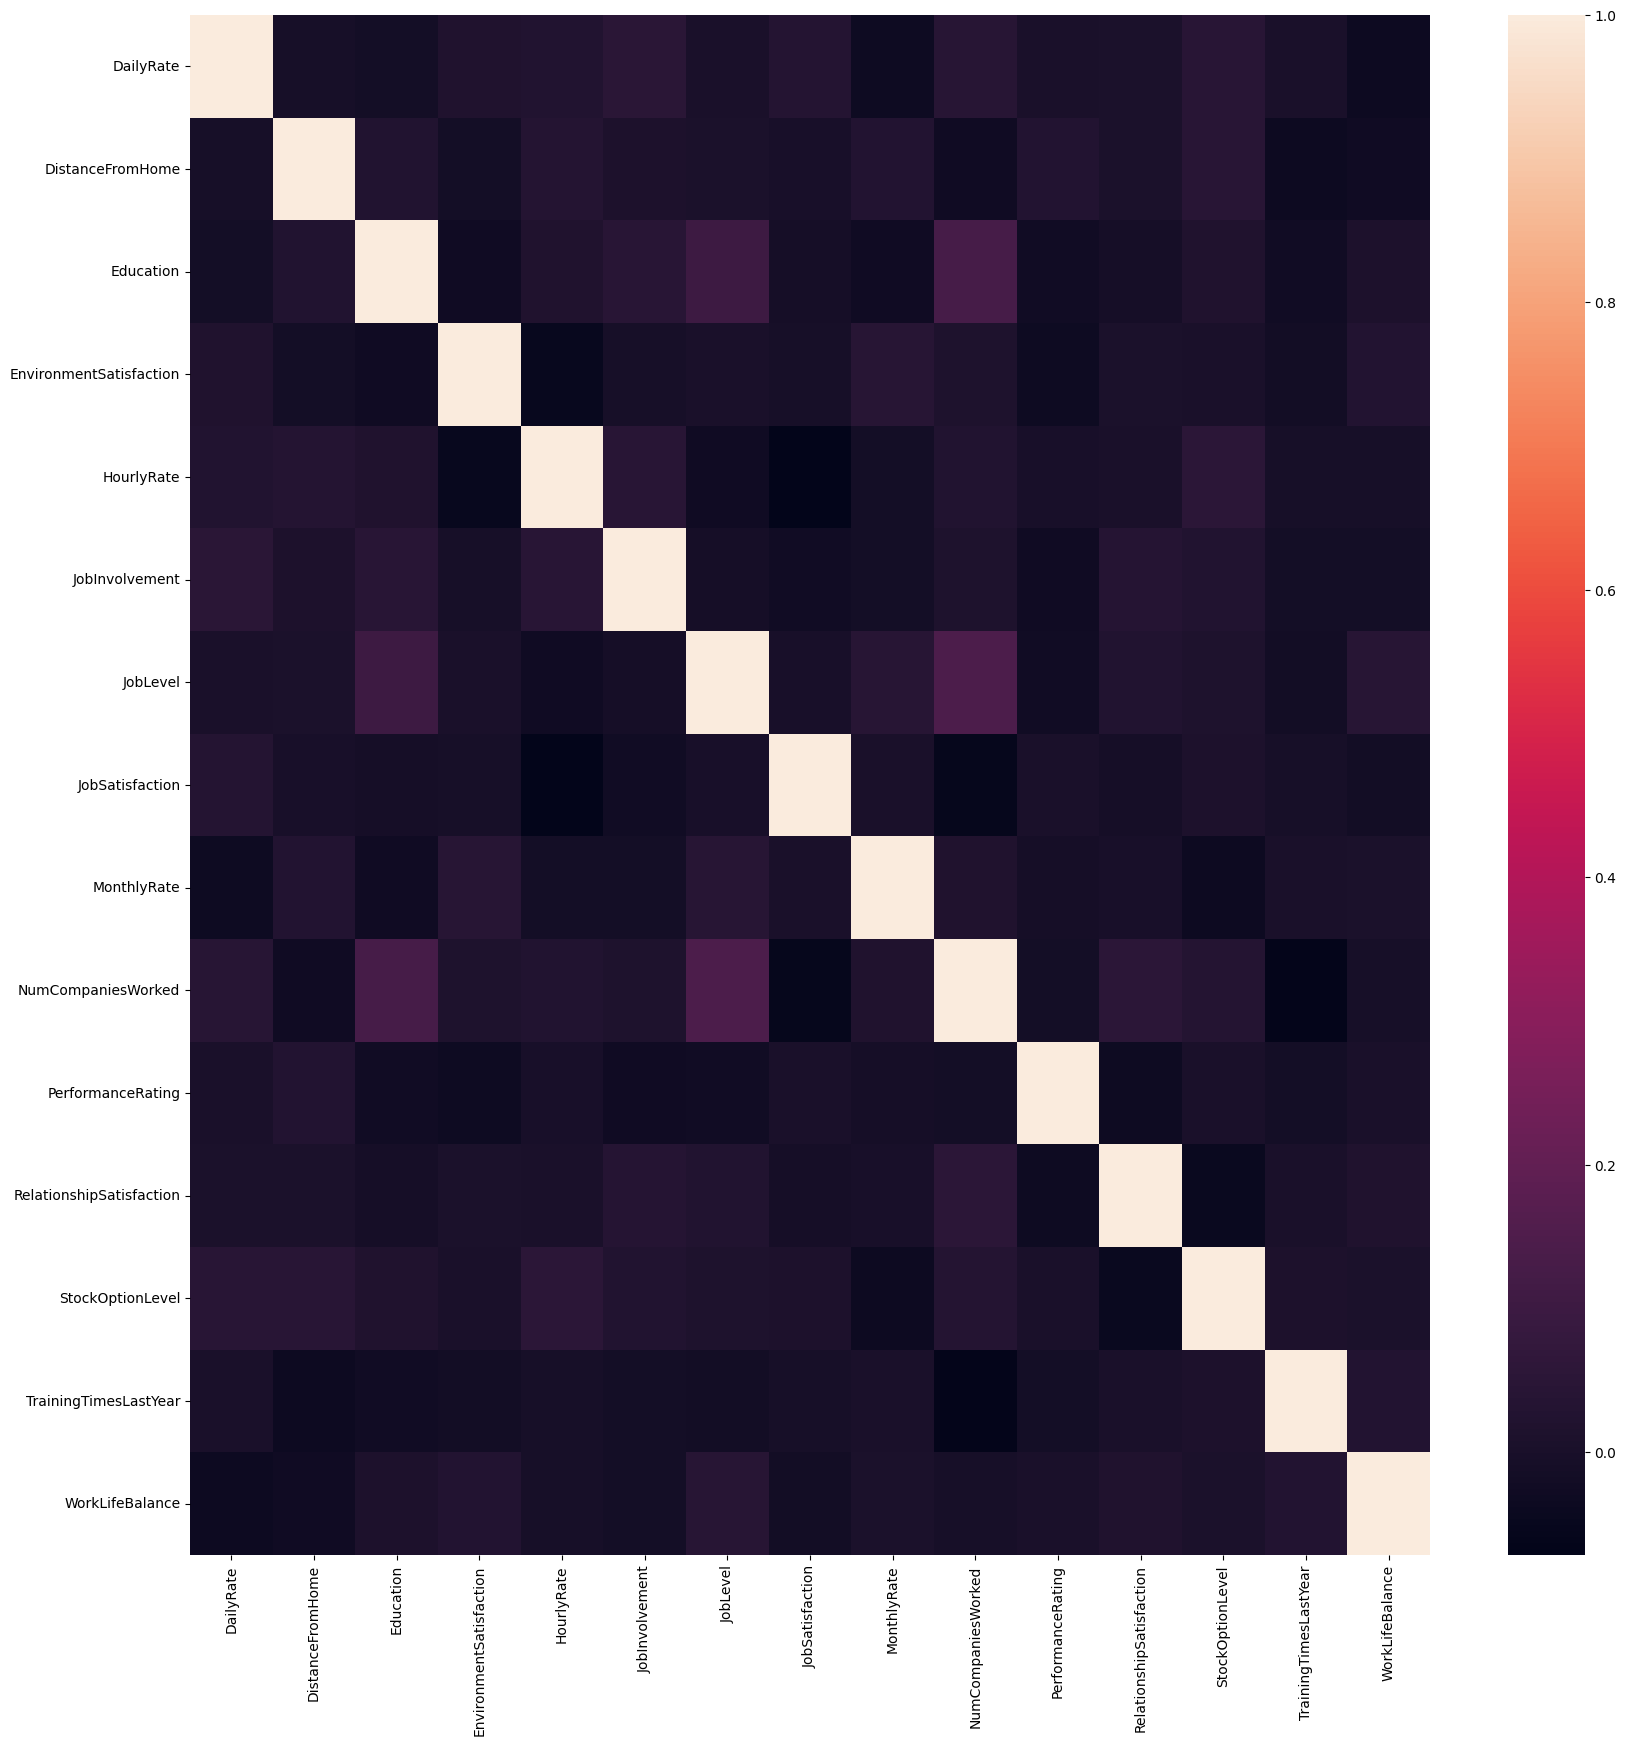

In [10]:
correlation = df.drop(columns="Emp_Attrition").select_dtypes("number")
# plot correlation heatmap
set_option('display.width', 100)
plt.figure(figsize = (20,20))
sns.heatmap(correlation.corr(), annot=False);

In [11]:
print(df.shape)
df.head()

(1470, 23)


,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,Emp_Attrition
0,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,...,Single,19479,8,Yes,3,1,0,0,1,1
1,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,...,Married,24907,1,No,4,4,1,3,3,0
2,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,...,Single,2396,6,Yes,3,2,0,3,3,1
3,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,...,Married,23159,1,Yes,3,3,0,3,3,0
4,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,...,Married,16632,9,No,3,4,1,3,3,0


## EXPLORATION

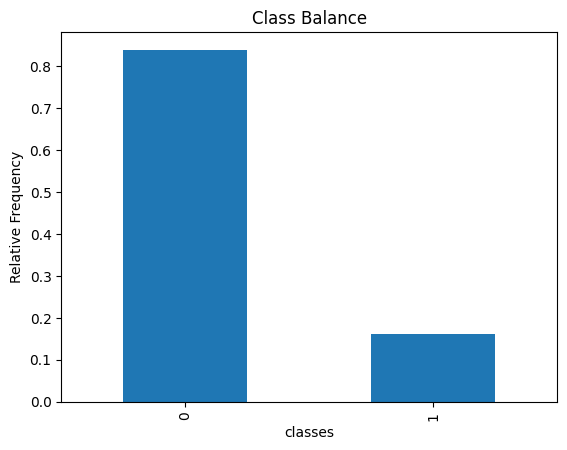

In [12]:
# Determining balance on my target feature by plotting a box plot
df["Emp_Attrition"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="classes",
    ylabel="Relative Frequency",
    title= "Class Balance"
);

From the visualization above it is clear there is data imbalance on the target class and hence the need to be rectified.
This may lead to poor results when it comes to generalizing because the model wuold have seen more of "0" (majority)/ Negative class than the "1" (minority)/ positive class.

class 1 is positive because these are employees that are likely to leave the company and 0 is negative `No` these employees would rather stay and they are the majority. This company must be really treating its employees right will find out what features actually contribute to this later.

The visualization also indicates that majority of the employees are satisfied with the work environment and even the pay.<br>
This is beause `0` represents `No` for the employees not likely to leave the firm and `1` other wise.

In [13]:
df["Emp_Attrition"].value_counts()

0    1233
1     237
Name: Emp_Attrition, dtype: int64

In [14]:
majority_class, minority_class = df["Emp_Attrition"].value_counts(normalize=True)
print(majority_class, minority_class)

0.8387755102040816 0.16122448979591836


/tmp/ipykernel_75/877074553.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.select_dtypes("number").drop(columns="Emp_Attrition").hist(ax=ax);


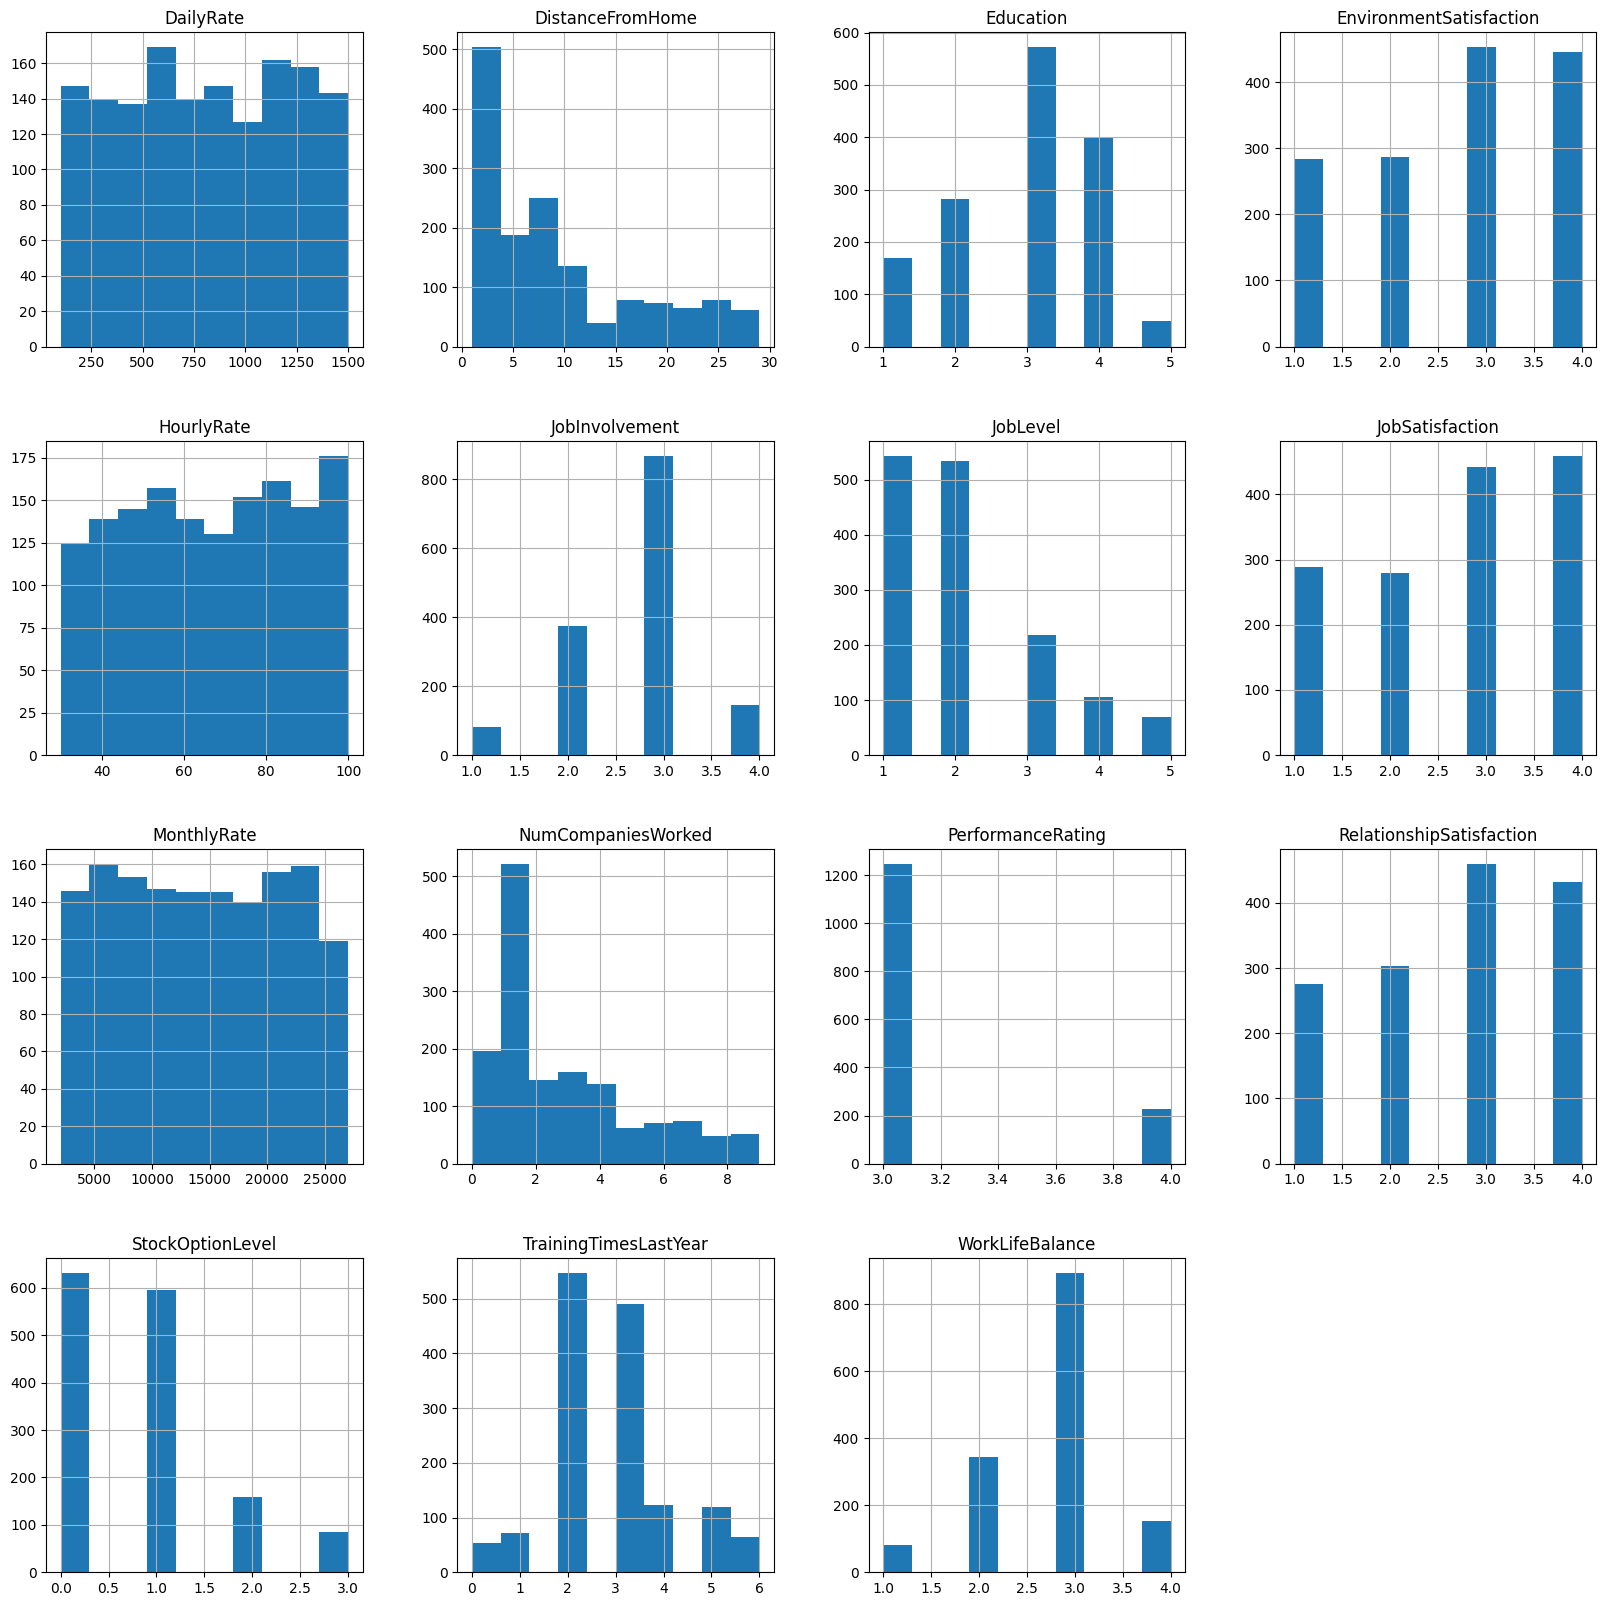

In [15]:
fig, ax = plt.subplots(figsize= (20, 20))
df.select_dtypes("number").drop(columns="Emp_Attrition").hist(ax=ax);

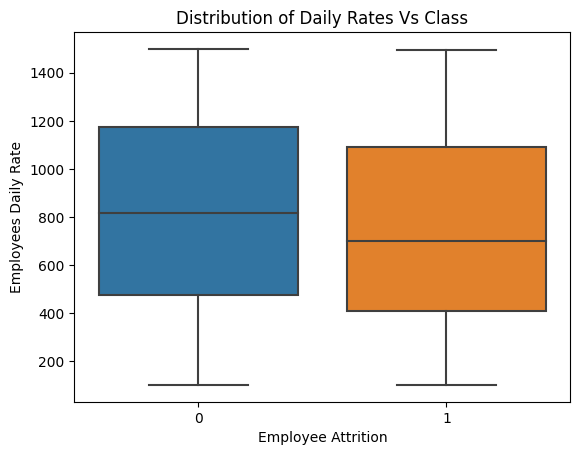

In [16]:
# box plot to show distribution on daily rate verses class balance using seaborn
sns.boxplot(x = "Emp_Attrition", y = "DailyRate", data = df)
plt.xlabel("Employee Attrition")
plt.ylabel("Employees Daily Rate")
plt.title("Distribution of Daily Rates Vs Class");

From the box plot above most employees getting a daily wage of about 800 are unlikely to leave the company whereas those getting a daily rate of 700 are the once most likely to leave.<br>
We can also see there are no outliers on this data to mean no outragious daily rates.The maximum an employee gets per day is about 1400

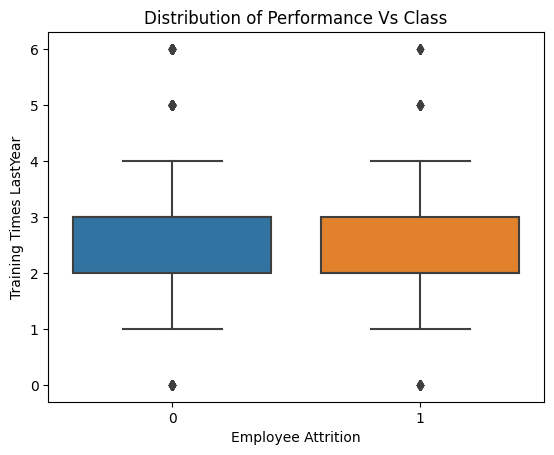

In [17]:
# box plot to show distribution on Performance rating verses class balance using seaborn
sns.boxplot(x = "Emp_Attrition", y = "TrainingTimesLastYear", data = df)
plt.xlabel("Employee Attrition")
plt.ylabel("Training Times LastYear")
plt.title("Distribution of Performance Vs Class");

Are employees really certisfied with their working environment?
Determining relationship between employees EnvironmentSatisfaction and whether or not they are likely to leave the company.<br>
Using pivot plot to determine this particular relationship.<br>

In [18]:
_piv = pd.pivot_table(
    df,
    index = "EnvironmentSatisfaction",
    values = "Emp_Attrition",
    aggfunc = np.mean).sort_values(by = "Emp_Attrition")
_piv.head()

,Emp_Attrition
EnvironmentSatisfaction,
4,0.134529
3,0.136865
2,0.149826
1,0.253521


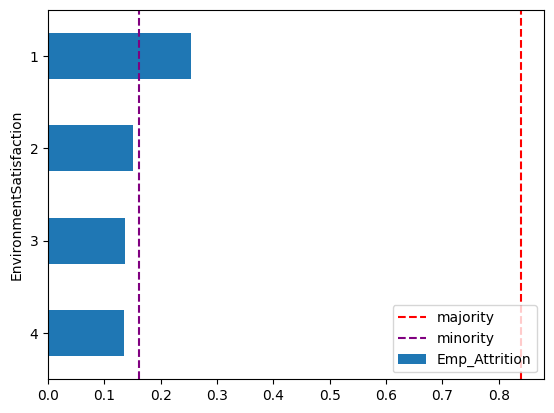

In [19]:
#Plotting horizontal bar chart of monthly_piv
_piv.plot(
    kind = "barh",
    legend = None,
)
plt.axvline(
    majority_class,
    linestyle = "--", color="red", label="majority"
)
plt.axvline(
    minority_class,
    linestyle = "--", color="purple", label="minority"
)
plt.legend(loc = "lower right");

From the above plot it is clear most employees are quite satisfied with their working environment hence most are likely not to leave the company.<br>

SPLIT THE DATA SET<br>
---
splittting the data into training and test sets so as not to interfere with the original data only after that can we conduct resampling on the data.<br>

In [20]:
# Vertical split
target = "Emp_Attrition"
X = df.drop(columns = "Emp_Attrition")
y = df[target]

In [21]:
# Horizontal split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test:", y_test.shape)

X_train shape: (1176, 22)
y_train shape: (1176,)
X_test shape: (294, 22)
y_test: (294,)


In [22]:
#creating a 10% validation set from the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = 42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val:", y_val.shape)

X_train shape: (1058, 22)
y_train shape: (1058,)
X_val shape: (118, 22)
y_val: (118,)


RESAMPLING
---

In [23]:
#under resampling: Note under sampling is not the best as most data tend to be lost as will see from the model
resample_under = RandomUnderSampler(random_state = 42)
X_train_under, y_train_under = resample_under.fit_resample(X_train, y_train)
print("X_train_under shape:", X_train_under.shape)
print("y_train_under shape:", y_train_under.shape)

X_train_under shape: (358, 22)
y_train_under shape: (358,)


In [24]:
# Over sampling
resample_over = RandomOverSampler(random_state = 42)
X_train_over, y_train_over = resample_over.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
print("y_train_over shape:", y_train_over.shape)

X_train_over shape: (1758, 22)
y_train_over shape: (1758,)


BUILD MODEL
---
Building three models one reg, under for under sampled data set and another for the oversampled data set to see whichone beats the baseline.<br>
First create a baseline from the regular training data `y_train`

BASELINE MODEL
---

In [29]:
base_acc = y_train.value_counts(normalize = True).max().round(4)
base_acc

0.8308

The baseline accuracy is 83%...Which model beats this baseline??

In [30]:
# This is a Logistic regression model hence the need for OneHotEncoder
# Reg model
reg_model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    LogisticRegression(max_iter= 3000)
)
reg_model.fit(X_train, y_train)

# model_under : dataset from under sampling
model_under = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    LogisticRegression(max_iter= 3000) 
)
model_under.fit(X_train_under, y_train_under)

# model_over : dataset from over sampling
model_over = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    LogisticRegression(max_iter= 3000) 
)
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['BusinessTravel', 'Department',
                                     'EducationField', 'Gender', 'JobRole',
                                     'MaritalStatus', 'OverTime'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=3000))])

Evaluate
---
Evaluating the models to determine the best amongst the three

In [31]:
for m in [reg_model, model_under, model_over]:
    acc_training = m.score(X_train, y_train)
    acc_val_test = m.score(X_val, y_val)
    
    print("Training Accuracy:", round(acc_training, 4))
    print("Validation Accuracy:", round(acc_val_test, 4))

Training Accuracy: 0.8733
Validation Accuracy: 0.9068
Training Accuracy: 0.7335
Validation Accuracy: 0.7542
Training Accuracy: 0.7722
Validation Accuracy: 0.7627


In [33]:
# checking how the model performs on test data using the regular model only this time as its the one that did beat the baseline.
test_acc = reg_model.score(X_test, y_test)
test_acc.round(4)

0.8673

CONFUSION MATRIX
---
The regular model is the only one beating the baseline as compared to the resampled ones,...<br>
but it is not party time yet since the data was imbalance hence the need to check what the confusion matrix says about the model's ability to generalize.

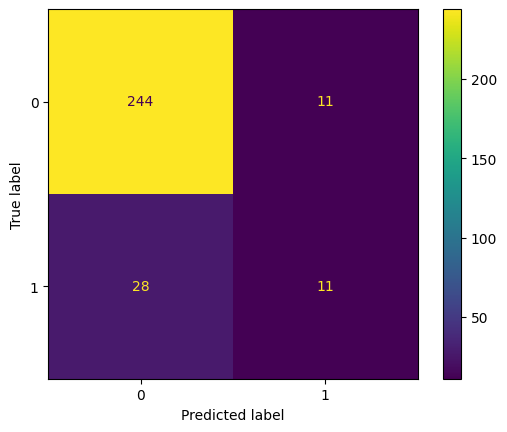

In [39]:
# plotting a confusion matrix on
ConfusionMatrixDisplay.from_estimator(reg_model, X_test, y_test);

From the matrix above the model perfoms very well on predicting the True Negative class `Employees not leaving the company`.<br>
But then it performs on avarange on predicting the True positive calss `Employees willing to leave the company` and again avarangely False positive.<br>

COMMUNICATION
---

Odds Ratio DataFrame
---

In [49]:
# Extracting feature names
features = reg_model.named_steps['onehotencoder'].get_feature_names()

# extracting as per importance of a feature
importances = reg_model.named_steps['logisticregression'].coef_[0]

# creating a pandas sSeries from the Importances and the features
odds_ratio = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratio.head()

OverTime_No                  0.414352
JobLevel                     0.609176
JobInvolvement               0.651652
BusinessTravel_Non-Travel    0.656132
MaritalStatus_Divorced       0.704602
dtype: float64

Odds Ratio I
---

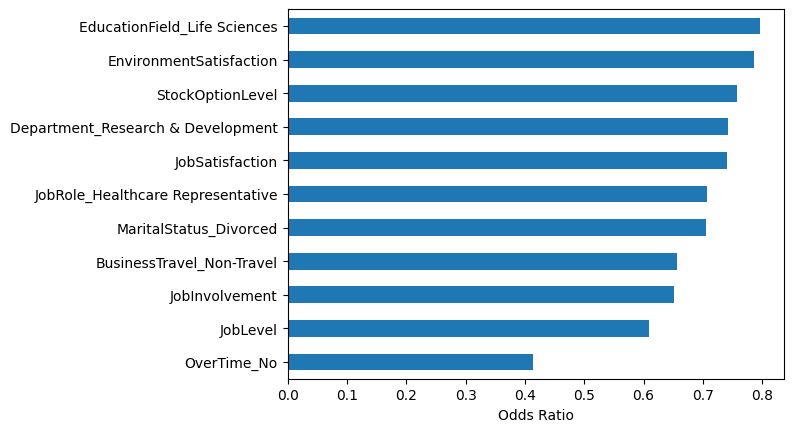

In [53]:
# Creating a visualization of the least important features in predicting Employee attrition
feat_imp.head(11).plot(
    kind = "barh"
)
plt.xlabel("Odds Ratio");

Odds Ratio II
---

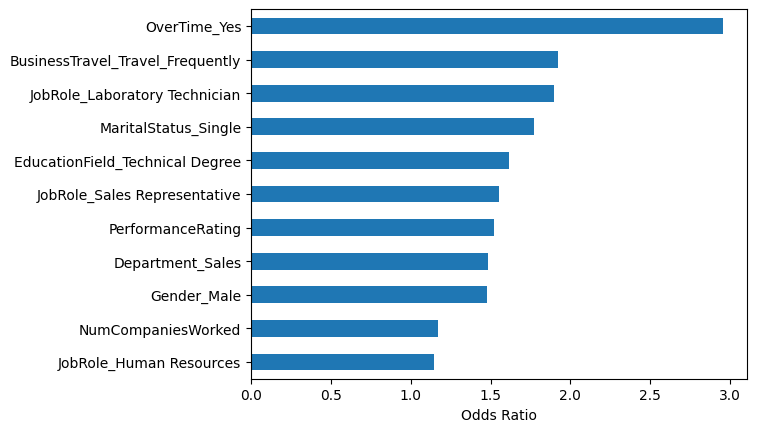

In [54]:
odds_ratio.tail(11).plot(
    kind = "barh"
)
plt.xlabel("Odds Ratio");

OverTime_Yes is the major predictive factor based on the communication above.<br>
Most all features on Odds Ratio II are all above `1` as compared to the least important features which all are below `0`